<a href="https://colab.research.google.com/github/sayan0506/Neural-Style-Transfer/blob/main/Fast_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are trying to implement the [Fast Neural Style Transfer](https://arxiv.org/abs/1705.06830), but rather implementing from scratch we will implement the model from **Tensorflow Hub** to generate stylized images

# Import Modules

In [2]:
try:
  # % tensorflow version only exists in collab
  %tensorflow_verion 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt 

# Utilities

In [35]:
def tensor_to_image(tensor):
  # Converts tensor to image
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    # assert is used to check whether the condition is True or not
    # that also used to check the network weights or layer type while building from scratch where the confirmation is needed
    assert tensor_shape[0] == 1
    tensor = tensor[0]
    # here the checking is whether image count m == 1 or not  
  return tf.keras.preprocessing.image.array_to_img(tensor)

# whatever the image we fetch we need to resize the image to a fixed scale to make it accessible through the Neural Network for executing style transfer
# thus we fetch image -> fetch the shapae -> find resoltuion -> cast image and shape dtype to float -> evaluate scale ratio w.r.t max res(512 here) -> rescale the shape ->  convert again to int
# reshape the iamge based on that ne shape -> add newaxis(as NN takes m,h,w,c) to make it 4 dimesional -> convert image type to original one uint8
def load_img(path_to_img):
  # loads an image as tensor and scales it to 512 pixels
  max_dim = 512
  print('Step-wise execution')
  image = tf.io.read_file(path_to_img)
  print(image.shape, image.dtype)
  image = tf.image.decode_jpeg(image)
  print(image.shape, image.dtype)
  image = tf.image.convert_image_dtype(image, tf.float32)
  print(image.shape, image.dtype)

  shape = tf.shape(image)[:-1]
  print(f'Current shape: {shape, shape.dtype}')
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  print(f'Casted shape {shape, shape.dtype}')
  long_dim = max(shape)
  scale = max_dim/ long_dim
  
  # the max dim we expect is resolution dimension based on that shape of image is rescaled by
  # the ratio max_dim/long_dim, and shape index are height, width(as upto :-1 it's fethced where -1 belongs to channel index)
  new_shape = tf.cast(shape * scale, tf.int32) 
  print(f'New shape {new_shape, new_shape.dtype}')
  image = tf.image.resize(image, new_shape)
  print(f'Resize image shape {image.shape, image.dtype}\n')
  # adding dimension to 0th index or m = 1 here
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

def load_images(content_path, style_path):
  # loads rhe content and style images as tensors
  content_image = load_img(f'{content_path}')
  style_image = load_img(f'{style_path}')
  
  return content_image, style_image

def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)

In [32]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg





print("image files you can choose from: ")
!ls images

mkdir: cannot create directory ‘images’: File exists
image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [33]:
# selecting images
content_path = f'{IMAGE_DIR}/tnj.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'

Step-wise execution
() <dtype: 'string'>
(450, 800, 3) <dtype: 'uint8'>
(450, 800, 3) <dtype: 'float32'>
Current shape: (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([450, 800], dtype=int32)>, tf.int32)
Casted shape (<tf.Tensor: shape=(2,), dtype=float32, numpy=array([450., 800.], dtype=float32)>, tf.float32)
New shape (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([288, 512], dtype=int32)>, tf.int32)
Resize image shape (TensorShape([288, 512, 3]), tf.float32)

Step-wise execution
() <dtype: 'string'>
(657, 1000, 3) <dtype: 'uint8'>
(657, 1000, 3) <dtype: 'float32'>
Current shape: (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 657, 1000], dtype=int32)>, tf.int32)
Casted shape (<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 657., 1000.], dtype=float32)>, tf.float32)
New shape (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([336, 512], dtype=int32)>, tf.int32)
Resize image shape (TensorShape([336, 512, 3]), tf.float32)

Image shape: (TensorShape([1, 288, 512, 3]), Ten

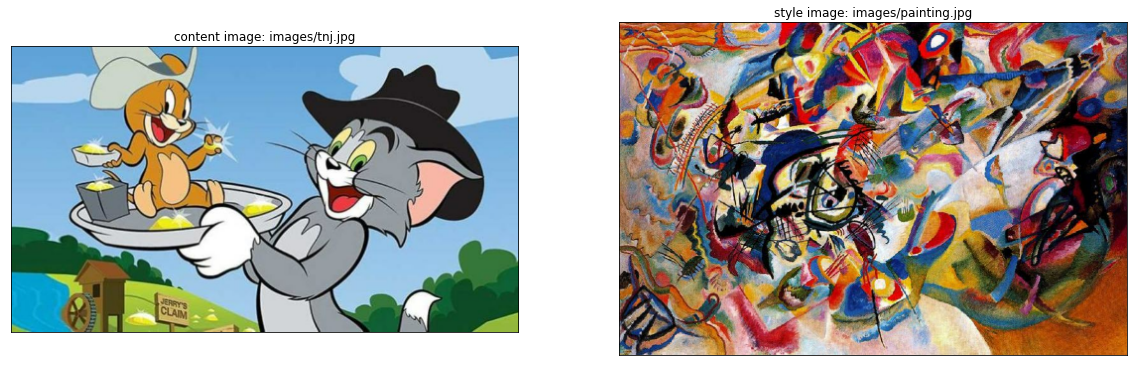

In [36]:

# display the content and style image
content_image, style_image = load_images(content_path, style_path)
print(f'Image shape: {content_image.shape, style_image.shape}')
print(f'Images are fetched as tensors: {type(content_image)}')
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

**Now our goal is to generate stylized image using these two**

# Download the model

In [37]:
# this will take a few minutes to load
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

**Demo 1**

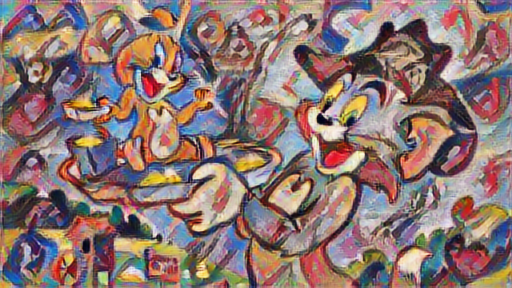

In [38]:
# stylize the image using the model you just downloaded
stylized_image = hub_module(tf.image.convert_image_dtype(content_image, tf.float32), 
                            tf.image.convert_image_dtype(style_image, tf.float32))[0]

# convert the tensor to image
tensor_to_image(stylized_image)

**Demo 2**

In [39]:
# selecting images
content_path = f'{IMAGE_DIR}/rudolph.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'

Step-wise execution
() <dtype: 'string'>
(905, 1280, 3) <dtype: 'uint8'>
(905, 1280, 3) <dtype: 'float32'>
Current shape: (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 905, 1280], dtype=int32)>, tf.int32)
Casted shape (<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 905., 1280.], dtype=float32)>, tf.float32)
New shape (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([362, 512], dtype=int32)>, tf.int32)
Resize image shape (TensorShape([362, 512, 3]), tf.float32)

Step-wise execution
() <dtype: 'string'>
(657, 1000, 3) <dtype: 'uint8'>
(657, 1000, 3) <dtype: 'float32'>
Current shape: (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 657, 1000], dtype=int32)>, tf.int32)
Casted shape (<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 657., 1000.], dtype=float32)>, tf.float32)
New shape (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([336, 512], dtype=int32)>, tf.int32)
Resize image shape (TensorShape([336, 512, 3]), tf.float32)



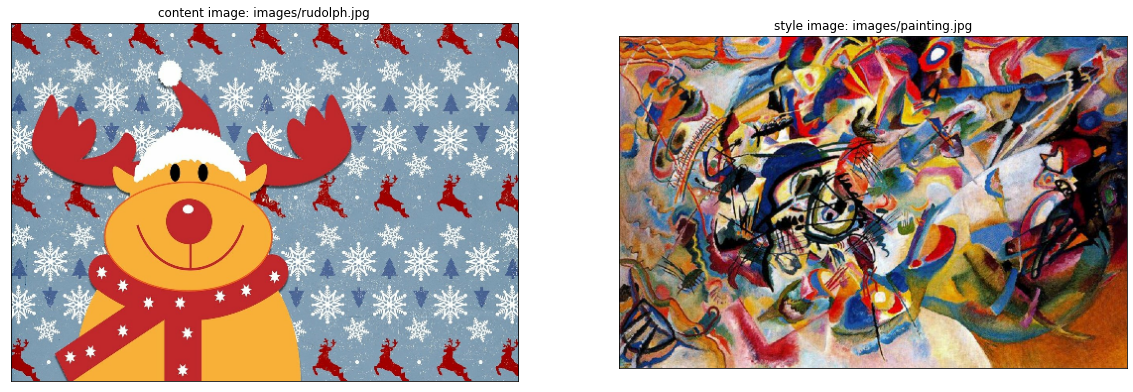

In [40]:

# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

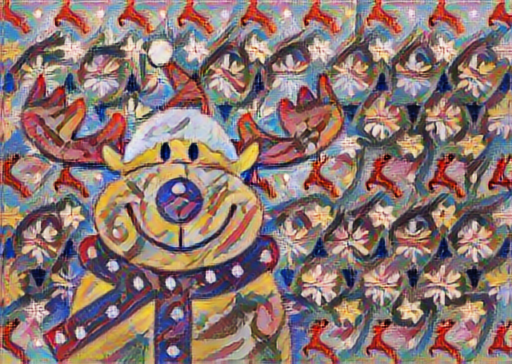

In [41]:
# stylize the image using the model you just downloaded
stylized_image = hub_module(tf.image.convert_image_dtype(content_image, tf.float32), 
                            tf.image.convert_image_dtype(style_image, tf.float32))[0]

# convert the tensor to image
tensor_to_image(stylized_image)